<a href="https://colab.research.google.com/github/abkimc/sym-rag-methods/blob/main/pysips_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pysips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.1/412.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.3/539.3 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 13.7 MB/s eta 0:00:00


In [2]:
# Standard library imports
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Scientific computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# PySIPS - our symbolic regression package
from pysips import PysipsRegressor

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✓ All imports successful")
print(f"✓ Random seed set to {RANDOM_SEED}")

✓ All imports successful
✓ Random seed set to 42


In [3]:
def generate_data(func, x_range, n_points=200, noise_level=0.1, n_features=1, seed=None):
    """
    Generate synthetic data from a given function with added noise.

    Parameters:
    -----------
    func : callable
        Function that takes X array and returns y values
    x_range : tuple
        (min, max) range for generating X values
    n_points : int
        Number of data points to generate
    noise_level : float
        Standard deviation of Gaussian noise
    n_features : int
        Number of input features
    seed : int
        Random seed for reproducibility

    Returns:
    --------
    X : ndarray
        Input features array of shape (n_points, n_features)
    y : ndarray
        Target values with added noise
    y_true : ndarray
        True target values without noise
    """
    rng = np.random.default_rng(seed)

    if n_features == 1:
        X = np.linspace(x_range[0], x_range[1], n_points).reshape(-1, 1)
    else:
        X = rng.uniform(x_range[0], x_range[1], (n_points, n_features))

    y_true = func(X)
    noise = rng.normal(0, noise_level, n_points)
    y = y_true + noise

    return X, y, y_true


def evaluate_model(regressor, X_train, y_train, X_test, y_test, y_test_true):
    """
    Comprehensive evaluation of a fitted regressor.

    Parameters:
    -----------
    regressor : PysipsRegressor
        Fitted PySIPS regressor
    X_train, y_train : ndarray
        Training data
    X_test, y_test : ndarray
        Test data (with noise)
    y_test_true : ndarray
        True test values (without noise)

    Returns:
    --------
    dict : Dictionary containing all evaluation metrics
    """
    # Make predictions
    y_pred_train = regressor.predict(X_train)
    y_pred_test = regressor.predict(X_test)

    # Calculate metrics
    metrics = {
        'expression': regressor.get_expression(),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'test_r2_true': r2_score(y_test_true, y_pred_test),  # R² on noiseless data
        'train_mse': mean_squared_error(y_train, y_pred_train),
        'test_mse': mean_squared_error(y_test, y_pred_test),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'predictions_train': y_pred_train,
        'predictions_test': y_pred_test,
    }

    return metrics


def plot_results(X_train, y_train, X_test, y_test, y_test_true, metrics, title):
    """
    Create comprehensive visualization of regression results.

    Parameters:
    -----------
    X_train, y_train : ndarray
        Training data
    X_test, y_test : ndarray
        Test data
    y_test_true : ndarray
        True test values (without noise)
    metrics : dict
        Dictionary with evaluation metrics and predictions
    title : str
        Plot title
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # For multivariate data, plot against first feature only
    if X_train.shape[1] == 1:
        x_train_plot = X_train.flatten()
        x_test_plot = X_test.flatten()
        x_label = 'x'
    else:
        x_train_plot = X_train[:, 0]
        x_test_plot = X_test[:, 0]
        x_label = 'x₀ (first feature)'

    # Plot 1: Fit visualization
    axes[0].scatter(x_train_plot, y_train, alpha=0.5, s=30, label='Training data')
    axes[0].scatter(x_test_plot, y_test, alpha=0.5, s=30, label='Test data', marker='s')

    # Sort for smooth line plotting
    if X_train.shape[1] == 1:
        sort_idx = np.argsort(X_train.flatten())
        axes[0].plot(X_train.flatten()[sort_idx],
                    metrics['predictions_train'][sort_idx],
                    'r-', linewidth=2, label='Prediction', alpha=0.8)

    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel('y')
    axes[0].set_title(f'{title}\nExpression: {metrics["expression"]}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Prediction vs Actual (Test set)
    axes[1].scatter(y_test, metrics['predictions_test'], alpha=0.6, s=40)
    min_val = min(y_test.min(), metrics['predictions_test'].min())
    max_val = max(y_test.max(), metrics['predictions_test'].max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    axes[1].set_xlabel('Actual y (test)')
    axes[1].set_ylabel('Predicted y')
    axes[1].set_title(f'Prediction Quality\nTest R² = {metrics["test_r2"]:.4f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Residuals
    residuals = y_test - metrics['predictions_test']
    axes[2].scatter(metrics['predictions_test'], residuals, alpha=0.6, s=40)
    axes[2].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[2].set_xlabel('Predicted y')
    axes[2].set_ylabel('Residuals (y - ŷ)')
    axes[2].set_title(f'Residual Analysis\nMSE = {metrics["test_mse"]:.4f}')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def print_metrics(metrics, runtime=None):
    """
    Print formatted evaluation metrics.

    Parameters:
    -----------
    metrics : dict
        Dictionary with evaluation metrics
    runtime : float, optional
        Runtime in seconds
    """
    print("\n" + "="*60)
    print("EVALUATION METRICS")
    print("="*60)
    print(f"Discovered Expression: {metrics['expression']}")
    print(f"\nTraining Performance:")
    print(f"  R² Score:  {metrics['train_r2']:.6f}")
    print(f"  MSE:       {metrics['train_mse']:.6f}")
    print(f"\nTest Performance (with noise):")
    print(f"  R² Score:  {metrics['test_r2']:.6f}")
    print(f"  MSE:       {metrics['test_mse']:.6f}")
    print(f"  MAE:       {metrics['test_mae']:.6f}")
    print(f"\nTest Performance (true signal):")
    print(f"  R² Score:  {metrics['test_r2_true']:.6f}")

    if runtime is not None:
        print(f"\nRuntime: {runtime:.2f} seconds")
    print("="*60 + "\n")


print("✓ Helper functions defined")

✓ Helper functions defined


In [4]:
print("\n" + "#"*60)
print("# TEST 4: COMPLEX EXPRESSION")
print("#"*60 + "\n")

# Generate data: y = x0^2 + 2*x1 - 3*x0*x1
def true_function_1(X):
    return X[:, 0]**2 + 2*X[:, 1] - 3*X[:, 0]*X[:, 1]

X, y, y_true = generate_data(
    func=true_function_1,
    x_range=(-2, 2),
    n_points=1000,
    noise_level=0.15,
    n_features=2,
    seed=RANDOM_SEED
)

X_train, X_test, y_train, y_test, y_true_train, y_true_test = train_test_split(
    X, y, y_true, test_size=0.2, random_state=RANDOM_SEED
)

print(f"Data generated: {len(X_train)} training, {len(X_test)} test samples")
print(f"Features: 2 (x₀, x₁)")
print(f"True equation: y = x₀² + 2x₁ - 3x₀x₁")
print(f"Noise level: σ = 0.15\n")


############################################################
# TEST 4: COMPLEX EXPRESSION
############################################################

Data generated: 800 training, 200 test samples
Features: 2 (x₀, x₁)
True equation: y = x₀² + 2x₁ - 3x₀x₁
Noise level: σ = 0.15



In [5]:
# Configure regressor for complex expression
regressor_1 = PysipsRegressor(
    operators=['+', '-', '*'],
    max_complexity=25,           # Higher complexity needed
    num_particles=200,           # More particles for better search
    num_mcmc_samples=15,
    max_time=180,                # Longer runtime for complex search
    model_selection='mode',
    random_state=RANDOM_SEED
)

print("Fitting model (this may take a few minutes)...")
start_time = time.time()
regressor_1.fit(X_train, y_train)
runtime_1 = time.time() - start_time
print(f"✓ Fitting completed in {runtime_1:.2f} seconds")

Fitting model (this may take a few minutes)...


[ mutation ratio: 0.58: : 100.00%|██████████| phi: 1.00000/1.0 [02:06<00:00


✓ Fitting completed in 129.26 seconds



EVALUATION METRICS
Discovered Expression: (2)(X_1) + (X_0)(-0.009398294198703638 + X_0 + (-2.995726487995129)(X_1))

Training Performance:
  R² Score:  0.998950
  MSE:       0.022957

Test Performance (with noise):
  R² Score:  0.999209
  MSE:       0.021528
  MAE:       0.116313

Test Performance (true signal):
  R² Score:  0.999993

Runtime: 129.26 seconds



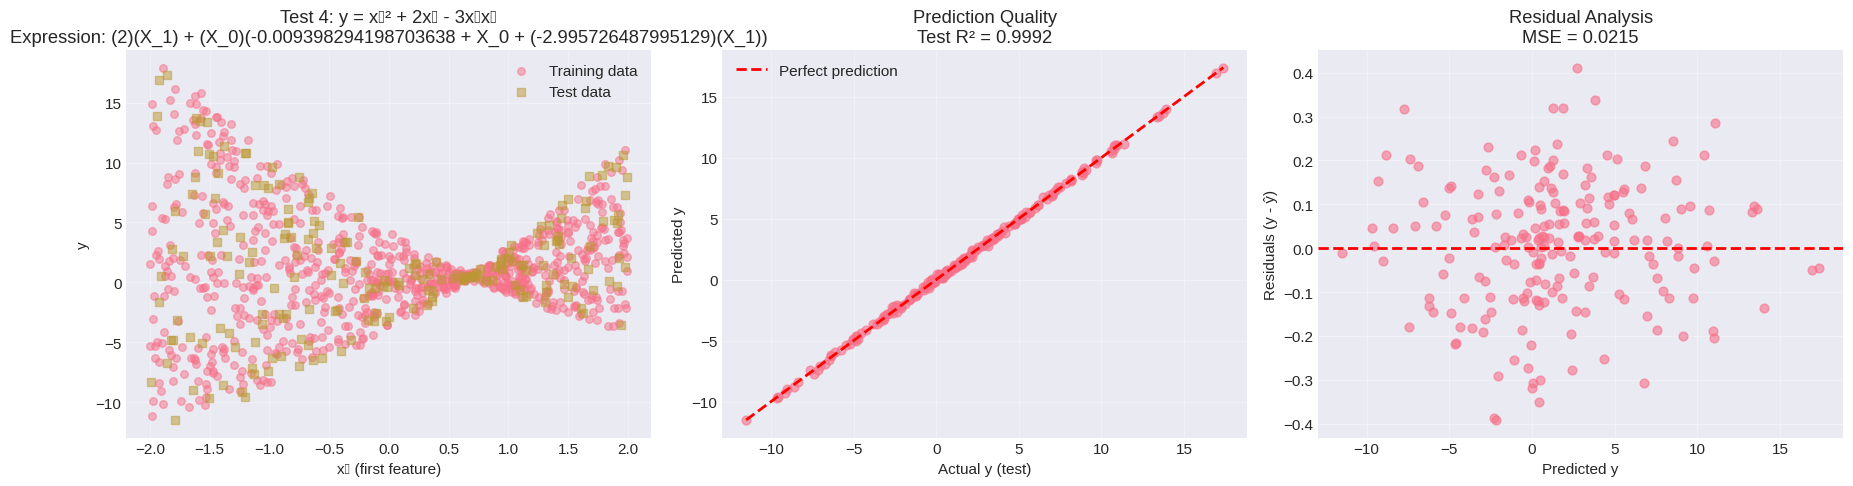

In [6]:
# Evaluate and visualize
metrics_1 = evaluate_model(regressor_1, X_train, y_train, X_test, y_test, y_true_test)
print_metrics(metrics_1, runtime_1)
plot_results(X_train, y_train, X_test, y_test, y_true_test, metrics_1,
             "Test 4: y = x₀² + 2x₁ - 3x₀x₁")

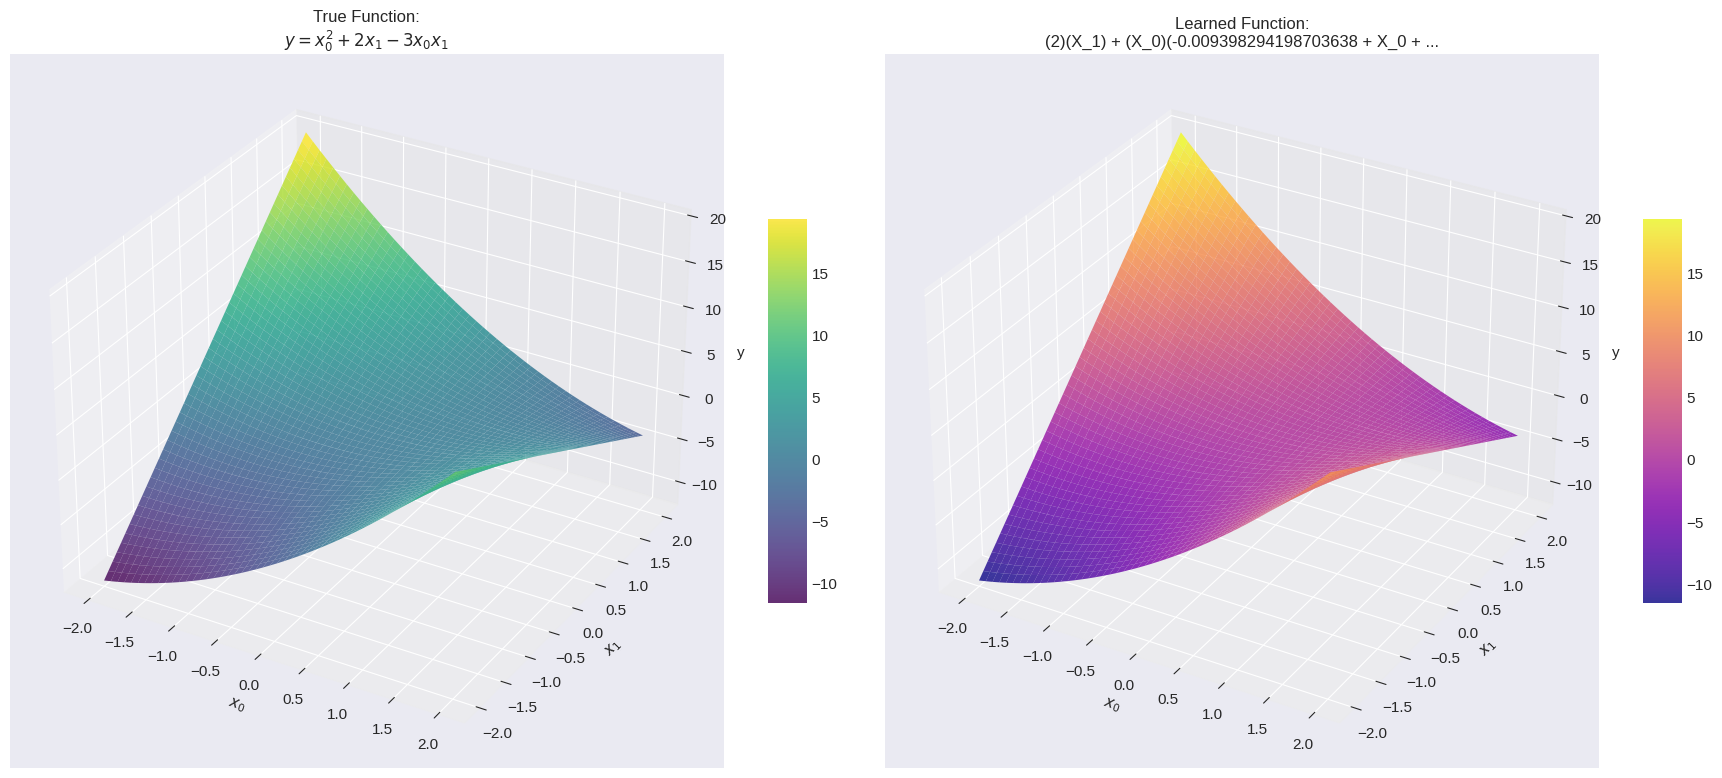

In [7]:
  import numpy as np
import matplotlib.pyplot as plt

def plot_3d_comparison(true_func, regressor, x_range=(-2, 2), points=50):
    """
    Generates side-by-side 3D surface plots for the true function and the regressor prediction.
    """
    # 1. Create a meshgrid
    x0 = np.linspace(x_range[0], x_range[1], points)
    x1 = np.linspace(x_range[0], x_range[1], points)
    X0, X1 = np.meshgrid(x0, x1)

    # 2. Flatten and stack to create input matrix of shape (N, 2)
    # This matches the format expected by regressor.predict()
    X_grid = np.column_stack((X0.ravel(), X1.ravel()))

    # 3. Calculate Z values
    # True function values
    Z_true = true_func(X_grid).reshape(X0.shape)

    # Predicted values from the regressor
    Z_pred = regressor.predict(X_grid).reshape(X0.shape)

    # 4. Create Plot
    fig = plt.figure(figsize=(18, 8))

    # --- Subplot 1: True Function ---
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X0, X1, Z_true, cmap='viridis',
                             edgecolor='none', alpha=0.8)
    ax1.set_title("True Function:\n$y = x_0^2 + 2x_1 - 3x_0x_1$", fontsize=12)
    ax1.set_xlabel('$x_0$')
    ax1.set_ylabel('$x_1$')
    ax1.set_zlabel('y')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

    # --- Subplot 2: Regressor Prediction ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X0, X1, Z_pred, cmap='plasma',
                             edgecolor='none', alpha=0.8)

    # Get expression string safely
    try:
        expr_str = regressor.get_expression()
        # Truncate if too long for the title
        if len(expr_str) > 50:
            expr_str = expr_str[:47] + "..."
    except:
        expr_str = "Prediction"

    ax2.set_title(f"Learned Function:\n{expr_str}", fontsize=12)
    ax2.set_xlabel('$x_0$')
    ax2.set_ylabel('$x_1$')
    ax2.set_zlabel('y')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

    plt.tight_layout()
    plt.show()

# Run the plotting function
# Ensure 'true_function_1' and 'regressor_1' are available from your previous code block
plot_3d_comparison(true_function_1, regressor_1)

In [8]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_interactive_comparison(true_func, regressor, x_range=(-2, 2), points=50):
    """
    Creates an interactive HTML-based 3D plot using Plotly.
    Plots: True Function | Predicted Function | Difference (Residuals)
    """

    # 1. Generate Grid
    x_vals = np.linspace(x_range[0], x_range[1], points)
    y_vals = np.linspace(x_range[0], x_range[1], points)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Flatten for prediction inputs
    flat_inputs = np.column_stack((X.ravel(), Y.ravel()))

    # 2. Calculate Z values
    # True values
    Z_true = true_func(flat_inputs).reshape(X.shape)

    # Predicted values
    Z_pred = regressor.predict(flat_inputs).reshape(X.shape)

    # Difference (Residuals): Prediction - True
    Z_diff = Z_pred - Z_true

    # 3. Create Subplots
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]],
        subplot_titles=(
            '<b>True Function</b><br>y = x₀² + 2x₁ - 3x₀x₁',
            '<b>Learned Model</b><br>(Prediction)',
            '<b>Difference (Error)</b><br>(Pred - True)'
        ),
        horizontal_spacing=0.05
    )

    # --- Plot 1: True Function ---
    fig.add_trace(
        go.Surface(
            x=X, y=Y, z=Z_true,
            colorscale='Viridis',
            colorbar=dict(x=0.28, len=0.5, title='True y'),
            opacity=0.9
        ),
        row=1, col=1
    )

    # --- Plot 2: Learned Function ---
    fig.add_trace(
        go.Surface(
            x=X, y=Y, z=Z_pred,
            colorscale='Viridis',
            colorbar=dict(x=0.62, len=0.5, title='Pred y'),
            opacity=0.9
        ),
        row=1, col=2
    )

    # --- Plot 3: Difference (Residuals) ---
    # We use a diverging colorscale (Red-White-Blue) to see
    # positive errors vs negative errors clearly.
    fig.add_trace(
        go.Surface(
            x=X, y=Y, z=Z_diff,
            colorscale='RdBu',
            # Force 0 to be the center color (white/grey)
            cmin=-np.max(np.abs(Z_diff)),
            cmax=np.max(np.abs(Z_diff)),
            colorbar=dict(x=0.97, len=0.5, title='Error'),
            opacity=0.9
        ),
        row=1, col=3
    )

    # 4. Layout updates for better interaction
    camera = dict(eye=dict(x=1.5, y=1.5, z=1.2)) # Default camera angle

    fig.update_layout(
        title_text=f"Interactive 3D Regression Analysis<br>Learned: {regressor.get_expression()}",
        title_x=0.5,
        height=700,
        width=1600, # Wide layout
        margin=dict(l=10, r=10, b=10, t=80),
        scene1=dict(aspectmode='cube', xaxis_title='x0', yaxis_title='x1', zaxis_title='y', camera=camera),
        scene2=dict(aspectmode='cube', xaxis_title='x0', yaxis_title='x1', zaxis_title='y', camera=camera),
        scene3=dict(aspectmode='cube', xaxis_title='x0', yaxis_title='x1', zaxis_title='Diff', camera=camera),
    )

    fig.show()

# Run the interactive plot
plot_interactive_comparison(true_function_1, regressor_1)